In [657]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import h5py

# Astrostats Capstone Project
#### Jaelyn Roth
#### 26 April 2024
#### Investigation into relative separation of a black hole binary as a function of redshift in the Astrid simulation
Please excuse any weird markdown issues at the top, some cells are disappearing and reappearing at whim.

Load data. This data is preliminary below z = 2, so I cannot send the datafile. If it presents a problem for reproducing the plots, I can try to limit the dataset to only mergers occuring above z = 2 and send that along, though the results will likely change. 

In [387]:
# load data
# should have mass, redshift, remnant galaxy mass and merging separation for each merger event
filename = '/home/rothj1/Desktop/Kelly_Research/Astrid_v2.0.hdf5'

# get file and main keys 
f = h5py.File(filename, "r")
mainKeys = f.keys()
print('Main keys:',mainKeys)

# subkeys
AllBHs = list(f['AllBHs'])
Binaries = list(f['Binaries'])
Header = list(f['Header'])
print('Subkeys:',AllBHs,Binaries,Header)


# inside subkeys
print('Inside subkey0:',list(f['AllBHs']['Z02.00000000']))
print('Inside subkey1:',list(f['Binaries']['NoDelay']))
print('Inside subkey2:',list(f['Header']['units']))

# actual data categories

# inside AllBHs
all_bhs = np.array(f['AllBHs']['Z02.00000000']['BlackHoles'])
all_gxies = np.array(f['AllBHs']['Z02.00000000']['Galaxies'])
print()
print('Inside AllBHs BHs:',all_bhs)
print('Inside AllBHs Galaxies',all_gxies)

# inside Binaries
bin_bhs = np.array(f['Binaries']['NoDelay']['BlackHoles'])
bin_gxies = np.array(f['Binaries']['NoDelay']['Galaxies'])
print()
print('Inside Binaries BHs:',bin_bhs)
print('Inside Binaries Galaxies:',bin_gxies)



Main keys: <KeysViewHDF5 ['AllBHs', 'Binaries', 'Header']>
Subkeys: ['Z02.00000000'] ['NoDelay'] ['units']
Inside subkey0: ['BlackHoles', 'Galaxies']
Inside subkey1: ['BlackHoles', 'Galaxies']
Inside subkey2: []

Inside AllBHs BHs: ['Mass' 'Mdot' 'NumberDensity' 'RadEff']
Inside AllBHs Galaxies ['StellarMass']

Inside Binaries BHs: ['NumberDensity' 'PrimaryMass' 'Redshift' 'SecondaryMass' 'Separation']
Inside Binaries Galaxies: ['RemnantRedshift' 'RemnantStellarMass']


In [389]:
masses = f['AllBHs']['Z02.00000000']['BlackHoles']['Mass'][:]
mdots = f['AllBHs']['Z02.00000000']['BlackHoles']['Mdot'][:]
numberDensities = f['AllBHs']['Z02.00000000']['BlackHoles']['NumberDensity'][:]
radEffs = f['AllBHs']['Z02.00000000']['BlackHoles']['RadEff'][:]
stellarMasses = f['AllBHs']['Z02.00000000']['Galaxies']['StellarMass'][:]


primaryMasses = f['Binaries']['NoDelay']['BlackHoles']['PrimaryMass'][:]
redshifts = f['Binaries']['NoDelay']['BlackHoles']['Redshift'][:]
secondaryMasses = f['Binaries']['NoDelay']['BlackHoles']['SecondaryMass'][:]
separations = f['Binaries']['NoDelay']['BlackHoles']['Separation'][:]
remnantRedshifts = f['Binaries']['NoDelay']['Galaxies']['RemnantRedshift'][:]
remnantStellarMasses = f['Binaries']['NoDelay']['Galaxies']['RemnantStellarMass'][:]

### Data Wrangling
First, take a look at the data with scatter plots and 2D histograms (heat map)

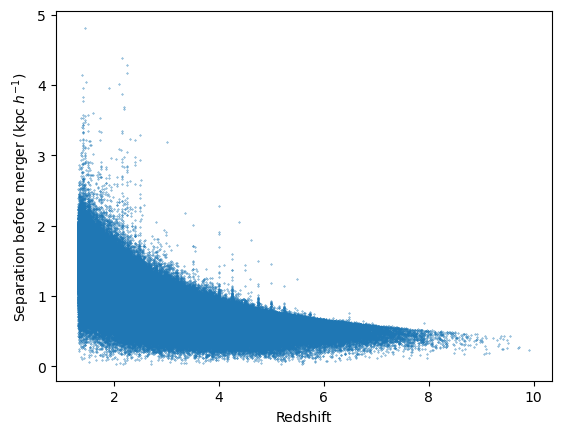

In [391]:
plt.figure()
plt.scatter(redshifts,separations,s=0.1)
plt.xlabel('Redshift')
plt.ylabel('Separation before merger (kpc $h^{-1}$)')
#plt.title('N = %i' % len(redshifts))
plt.show()

In [392]:
# make histogram
    # hist is an array with values corresponding to the counts per bin
hist, xedges, yedges = np.histogram2d(redshifts,separations,bins=100)

logHist = np.log10(hist)

# after doing the division, rewrite nans and infinities with zeros
for i in range(len(hist)):
    for j in range(len(hist[i])):
        if hist[i,j] == 0:
            logHist[i,j] = 0

minz = min(redshifts)
maxz = max(redshifts)
minSep = min(separations)
maxSep = max(separations)


/tmp/ipykernel_738275/3213915287.py:5: RuntimeWarning: divide by zero encountered in log10
  logHist = np.log10(hist)


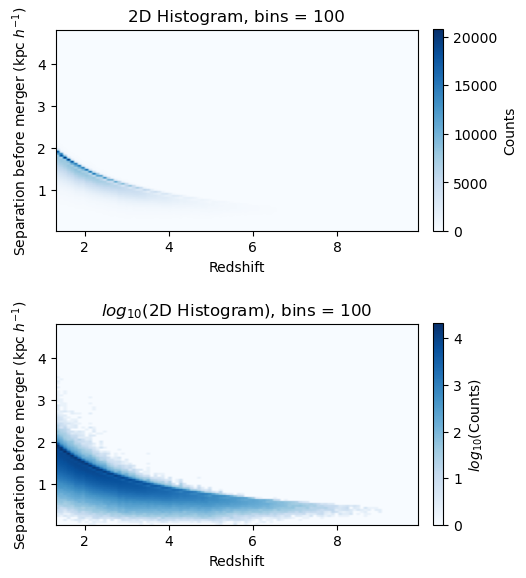

In [393]:
fig, axes = plt.subplots(2,1,figsize=(5,7))

im = axes[0].imshow(hist.T,origin='lower',extent=[minz,maxz,minSep,maxSep],cmap='Blues')
axes[0].set_title('2D Histogram, bins = 100')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('Separation before merger (kpc $h^{-1}$)')
cbar = plt.colorbar(im, fraction=0.026, pad=0.04)
cbar.set_label('Counts')

im2 = axes[1].imshow(logHist.T,origin='lower',extent=[minz,maxz,minSep,maxSep],cmap='Blues')
axes[1].set_title('$log_{10}$(2D Histogram), bins = 100')
axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('Separation before merger (kpc $h^{-1}$)')
cbar2 = plt.colorbar(im2, fraction=0.026, pad=0.04)
cbar2.set_label('$log_{10}$(Counts)')
plt.show()

Take the 2d histogram and plot any bin that has nonzero counts as one scatter point with the average separation and redshift for that bin.

(100, 100)


/tmp/ipykernel_738275/80788626.py:5: RuntimeWarning: invalid value encountered in divide
  newhist = hist/hist


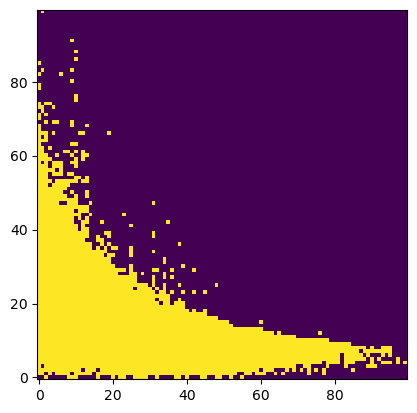

In [397]:
# get 2d histogram again
hist, xedges, yedges = np.histogram2d(redshifts,separations,bins=100)

# turn into 1s and nans
newhist = hist/hist

# turn nans to 0s
for i in range(len(hist)):
    for j in range(len(hist[i])):
        if hist[i,j] == 0:
            newhist[i,j] = 0

finalhist = newhist.T # redshift along horizontal axis, sep along vertical
print(finalhist.shape)
plt.imshow(finalhist,origin='lower') # show the mask
plt.show()

In [398]:
# get average redshift and separation per bin by averageing xedges values
avg_z_perbin = []
avg_sep_perbin = []

for i in range(len(xedges)-1):
    zleft = xedges[i]
    zright = xedges[i+1]
    sepleft = yedges[i]
    sepright = yedges[i+1]

    zavg = (zleft + zright)/2
    avg_z_perbin.append(zavg)
    sepavg = (sepleft + sepright)/2
    avg_sep_perbin.append(sepavg)

print(len(avg_z_perbin))
print(len(avg_sep_perbin))
print(avg_z_perbin)

100
100
[1.3591465011203134, 1.4451282737961948, 1.5311100464720762, 1.6170918191479573, 1.7030735918238387, 1.78905536449972, 1.8750371371756014, 1.9610189098514825, 2.047000682527364, 2.132982455203245, 2.218964227879127, 2.3049460005550078, 2.3909277732308896, 2.4769095459067705, 2.562891318582652, 2.648873091258533, 2.7348548639344146, 2.820836636610296, 2.906818409286177, 2.9928001819620587, 3.0787819546379396, 3.1647637273138214, 3.2507454999897023, 3.336727272665584, 3.422709045341465, 3.508690818017347, 3.5946725906932278, 3.6806543633691087, 3.7666361360449905, 3.8526179087208714, 3.938599681396753, 4.024581454072634, 4.110563226748516, 4.196544999424397, 4.282526772100279, 4.36850854477616, 4.454490317452041, 4.540472090127922, 4.626453862803803, 4.712435635479685, 4.798417408155566, 4.884399180831448, 4.970380953507329, 5.0563627261832105, 5.142344498859091, 5.228326271534973, 5.314308044210854, 5.400289816886735, 5.486271589562617, 5.572253362238499, 5.65823513491438, 5.744

In [399]:
# plot a scatter point at each nonzero location in hist with avg z and sep values

reds = []
seps = []

for rowidx in range(len(finalhist)):
    for colidx in range(len(finalhist[rowidx])):
        if finalhist[rowidx,colidx] == 1:
            reds.append(avg_z_perbin[rowidx])
            seps.append(avg_sep_perbin[colidx])

print(len(reds))
print(len(seps))

2115
2115


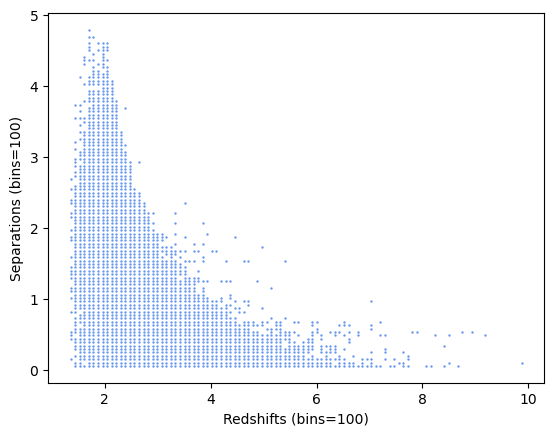

In [400]:
reds = np.array(reds)
seps = np.array(seps)
plt.scatter(reds,seps,s=0.5,color='cornflowerblue')
plt.xlabel('Redshifts (bins=100)')
plt.ylabel('Separations (bins=100)')
plt.show()

### Model Fitting

First, we split the data for training and testing. We will be fitting (.fit) on the training data, and predicting (.predict) on the testing data. We also need a cross-validation set to explore any hyper-parameters, in this case, the degree required for polynomial-regression. 

In [407]:
from sklearn.model_selection import train_test_split

# split 80% into training, 20% into test
xtrain, xtest, ytrain, ytest = train_test_split(reds, seps,test_size=0.2)

# split 50% off of the test set to be the cross validation set (10% of total data)
    # test is normally the thing test_size is applied to so call it CV in the output, rewrite test set so they are now smaller
xtest, xcv, ytest, ycv = train_test_split(xtest,ytest,test_size=0.5)

# check that sizes are about 80, 10, 10
print(len(xtrain)/len(reds))
print(len(xtest)/len(reds))
print(len(xcv)/len(reds))

0.8
0.09976359338061466
0.10023640661938535


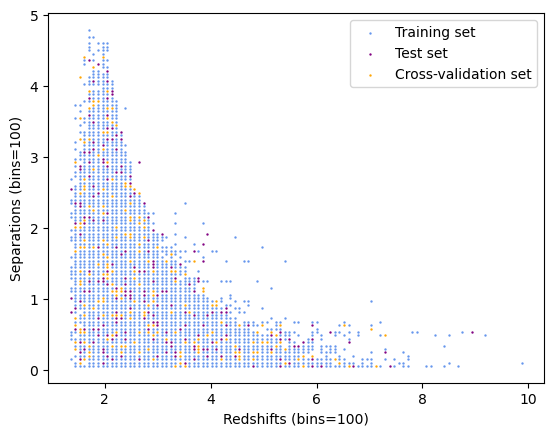

In [408]:
# visualize the spread of the sets
plt.scatter(xtrain,ytrain,s=0.5,color='cornflowerblue',label='Training set')
plt.scatter(xtest,ytest,s=0.5,color='purple',label='Test set')
plt.scatter(xcv,ycv,s=0.5,color='orange',label='Cross-validation set')
plt.xlabel('Redshifts (bins=100)')
plt.ylabel('Separations (bins=100)')
plt.legend()
plt.show()

### First, Linear Regression

In [409]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression(fit_intercept=True)
linReg.fit(xtrain.reshape(-1,1),ytrain.reshape(-1,1)) # try not reshaping ytrain
linFit = linReg.predict(xtest.reshape(-1,1))[:,0] # try not accepting 
print(linFit.shape)

print(linReg.coef_)
print(linReg.intercept_)

(211,)
[[-0.42462452]]
[2.64399055]


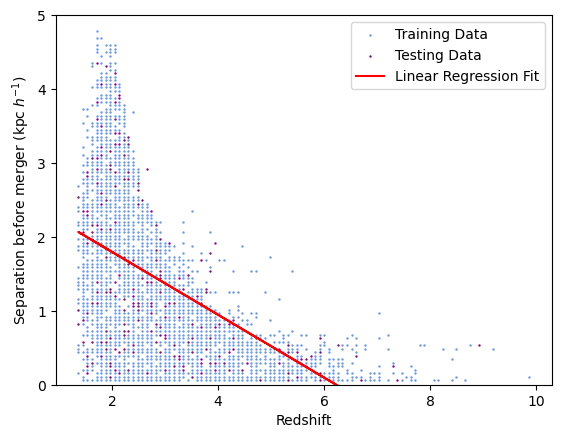

In [414]:
plt.scatter(xtrain,ytrain,s=0.5,color='cornflowerblue',label='Training Data')
plt.scatter(xtest,ytest,s=0.5,color='purple',label='Testing Data')

plt.plot(xtest,linFit,color='red',label='Linear Regression Fit')
plt.xlabel('Redshift')
plt.ylabel('Separation before merger (kpc $h^{-1}$)')
#plt.title('Linear Regression')
plt.ylim(0,5)
plt.legend()
plt.show()

### Then, Polynomial Regression

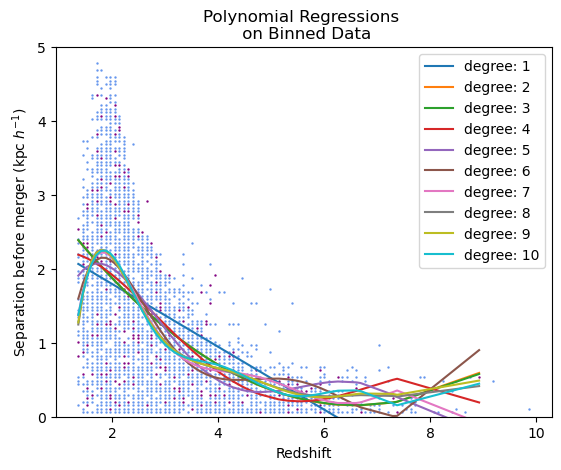

In [611]:
from astroML.linear_model import PolynomialRegression

degrees = np.array([1,2,3,4,5,6,7,8,9,10])
errs = np.zeros(degrees.shape)
bics = []

# iterate thru degrees
for i, deg in enumerate(degrees):

    # fit poly for that degree
    poly = PolynomialRegression(degree=deg)
    poly.fit(xtrain.reshape(-1,1),ytrain) # on train data
    coefs = poly.coef_
    
    # construct polynomials & plot
    fit = 0
    sortedxs = np.sort(xtest)
    
    for idx, co in enumerate(coefs):
        fit = fit + co*sortedxs**(idx) # on test data

    #fit = np.polyval(p=coefs, x=xtest, deg)
    plt.plot(sortedxs,fit,label='degree: %i'%deg)

    dy = 1 # don't have uncertainties associated with each data point
    k = deg + 1 # number of parameters
    N = len(seps) # number of data points
    
    # get BIC score
    err = np.sqrt(np.sum((fit - ytest) ** 2)/ len(ytest))
    errs[i] = err
    bic = np.sqrt(len(ytest)) * (err/dy) + k * np.log(N)
    bics.append(bic)

plt.scatter(xtrain,ytrain,s=0.5,color='cornflowerblue')
plt.scatter(xtest,ytest,s=0.5,color='purple')
plt.xlabel('Redshift')
plt.ylabel('Separation before merger (kpc $h^{-1}$)')
plt.title('Polynomial Regressions \n on Binned Data')
plt.ylim(0,5)
plt.legend()
plt.show()

Best degree = 1
[ 2.64399055 -0.42462452]


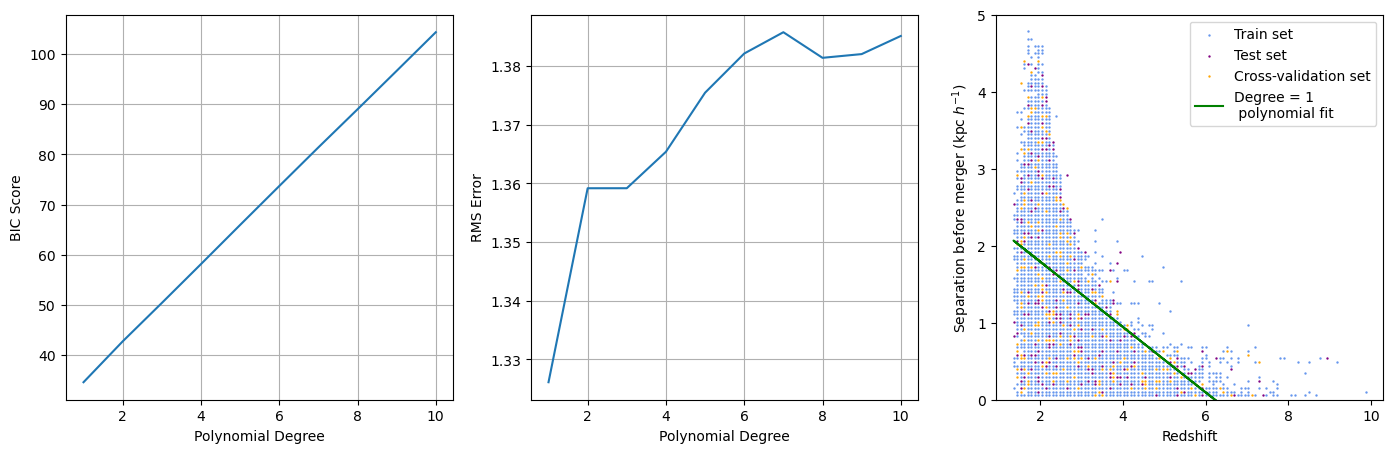

In [612]:
# Find degree that minimizes the BIC
best_idx = np.where(bics==min(bics))
best_deg = degrees[best_idx][0]
print('Best degree = %i' % best_deg)

# get the polynomial for that degree
best_poly = PolynomialRegression(degree=best_deg)
best_poly.fit(xtrain.reshape(-1,1),ytrain)
best_coefs = best_poly.coef_
print(best_coefs)

polyfit = 0
for idx, co in enumerate(best_coefs):
    polyfit = polyfit + co*xtest**(idx)


fig, axes = plt.subplots(1,3,figsize=(17,5))

axes[0].plot(degrees,bics)
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('BIC Score')
axes[0].grid()

axes[1].plot(degrees,errs)
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('RMS Error')
axes[1].grid()

axes[2].scatter(xtrain,ytrain,s=0.5,color='cornflowerblue',label='Train set')
axes[2].scatter(xtest,ytest,s=0.5,color='purple',label='Test set')
axes[2].scatter(xcv,ycv,s=0.5,color='orange',label='Cross-validation set')
axes[2].plot(xtest,polyfit,color='green',label='Degree = %i \n polynomial fit'%best_deg)
#axes[2].plot(xtest,linFit,color='red',linestyle='dotted',label='Linear fit')
axes[2].set_xlabel('Redshift')
axes[2].set_ylabel('Separation before merger (kpc $h^{-1}$)')
axes[2].set_ylim(0,5)
axes[2].legend()

#plt.suptitle('Choice of Optimal Degree for Polynomial Regression')
plt.show()

### Exponential Model with MCMC

In [34]:
# don't worry about any warning messages regarding mpi4py
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from scipy import stats
from scipy.stats import norm

Need to define model, likelihood function, priors, posterior. 

In [199]:
data = np.array([reds,seps])

def expModel(theta,data):
    # theta is a tuple with parameters A and lnB of the model: seps = A*exp(-B*reds)
    # data is array with [reds,seps]
    A, lnB = theta
    redvals = data[0]
    sepvals = data[1]

    fitvals = np.zeros(shape=redvals.shape)

    # iterate over redshifts
    for i in range(len(redvals)):
        expfit = A*np.exp(-(np.exp(lnB))*redvals[i]) # sign of B written into B, not into the model
        fitvals[i] = expfit
    
    return fitvals


def logL(theta):
    # theta is a tuple with parameters A and lnB of the model: seps = A*exp(-B*reds)
    # data is array with [reds,seps]

    sepvals = data[1]
    modelFits = expModel(theta,data)

    return sum(scipy.stats.norm.logpdf(*args)
               for args in zip(sepvals, modelFits))


def Prior(theta):
    # create a uniform prior in A and lnB
    Aprior = scipy.stats.uniform(0,30) # between 0 and 30
    lnBprior = scipy.stats.uniform(-2,4) # between -2 and 2

    Aval = Aprior.pdf(theta[0])
    lnBval = lnBprior.pdf(theta[1])

    prod_prior = Aval * lnBval

    return prod_prior

def logPrior(theta):
    return np.log(Prior(theta))

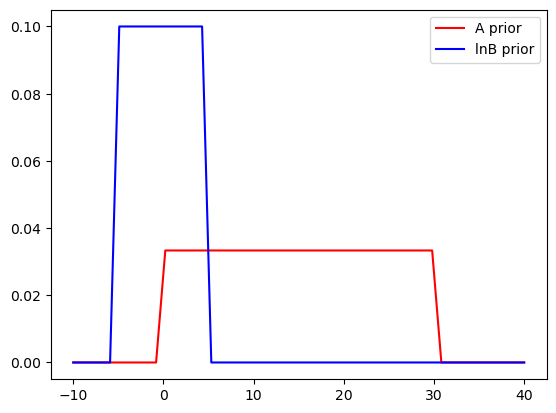

In [470]:
# visualize the priors
priorGrid = np.linspace(-10,40)
Aprior = scipy.stats.uniform(0,30)
lnBprior = scipy.stats.uniform(-5,10)

plt.plot(priorGrid,Aprior.pdf(priorGrid),color='red',label='A prior')
plt.plot(priorGrid,lnBprior.pdf(priorGrid),color='blue',label='lnB prior')
plt.legend()
#plt.title('Uniform Priors')
plt.show()

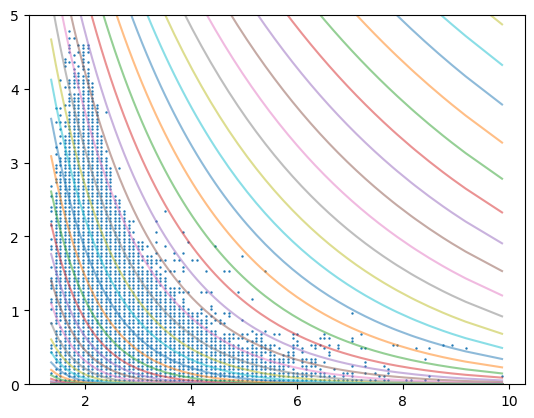

In [474]:
# check feasibility of priors on each parameter
plt.scatter(reds,seps,0.5)
for lnB in np.linspace(-5,5,100):
    plt.plot(reds,expModel(theta=[15,lnB],data=[reds,seps]),alpha=0.5)
plt.ylim(0,5)
plt.show()

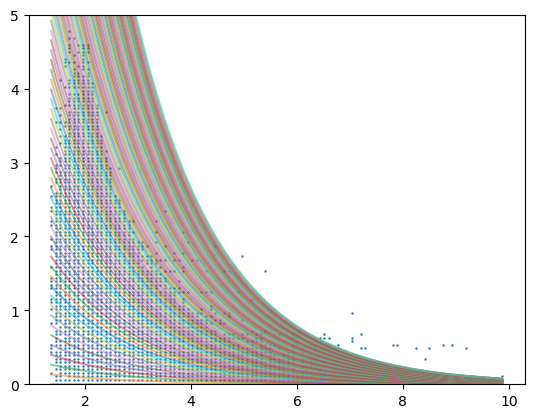

In [477]:
plt.scatter(reds,seps,0.5)
for A in np.linspace(0,30,100):
    plt.plot(reds,expModel(theta=[A,-0.5],data=[reds,seps]),alpha=0.5)
plt.ylim(0,5)
plt.show()

Now we can set up and run the MCMC in PTMCMCSampler.

In [203]:
# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_capstone_ptmcmc_chain', resume=False) # dumps into .txt file

In [204]:
# sampler for N steps
N = int(3e4)

# array of initial guesses
x0 = np.array([15, 0.2])

# run it! 
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50) # using same weights as Lecture 11

Finished 3.33 percent in 79.144026 s Acceptance rate = 0.651

/tmp/ipykernel_738275/2967269309.py:44: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(theta))


Finished 33.33 percent in 747.938350 s Acceptance rate = 0.175844Adding DE jump with weight 50
Finished 100.00 percent in 2501.205189 s Acceptance rate = 0.363233
Run Complete


Finished in ~42 minutes.

(3001, 6)


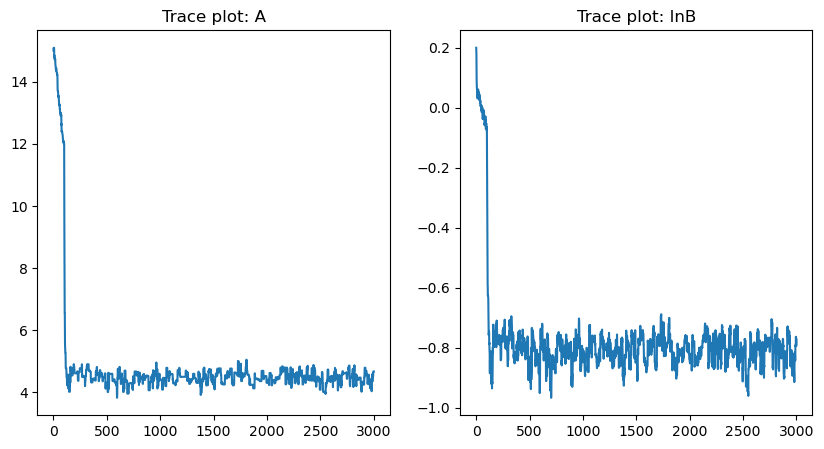

In [219]:
# Load in the chain
chain = np.loadtxt('./my_capstone_ptmcmc_chain/chain_1.txt') # first col 
print(chain.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(chain[:,0])
axes[1].plot(chain[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

Now we discard the burn in, which looks to be 100-200 points. 

(2801, 6)


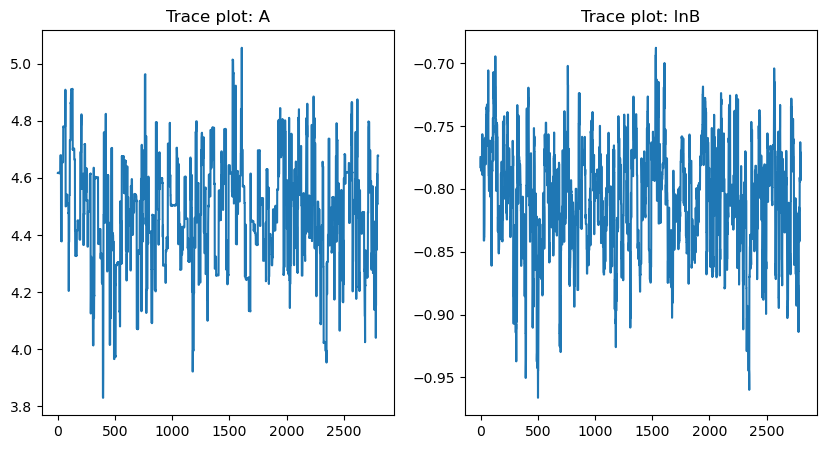

In [228]:
thinchain = chain[200:,:]
print(thinchain.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(thinchain[:,0])
axes[1].plot(thinchain[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

Then, we thin the chain by the autocorrelation length. Since the autocorrelation length represents the distance between independent samples, thinning the chain by this length makes every point in the chain an independent sample. Each parameter in the chain gets its own autocorrelation length, but if the chains are not the same size this could cause issues later, so the more conservative approach is to thin by the longest autocorrelation length of all the parameters. 

In [232]:
import acor
A_acor = acor.acor(thinchain[:,0])[0]
lnB_acor = acor.acor(thinchain[:,1])[0]
print(A_acor,lnB_acor)
# the first element of the tuple is the length between independent samples (auto-correlation)
# thin by the nearest integer.

19.231354115564088 18.230150319737824


(148, 6)


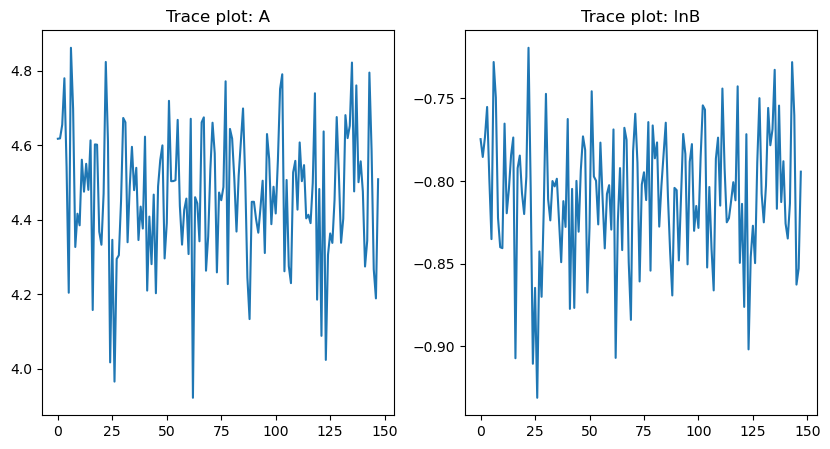

In [237]:
# plot only every 19th point
autochain = thinchain[::19]
print(autochain.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(autochain[:,0])
axes[1].plot(autochain[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

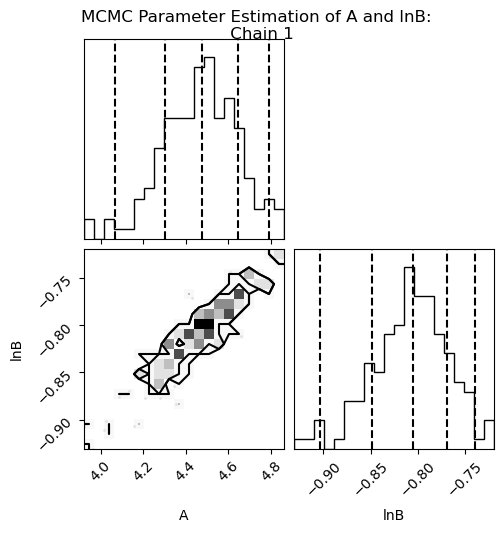

In [658]:
import corner
fig = corner.corner(autochain[:,:2],#take the first two columns
                    labels=['A','lnB'], 
                    quantiles = [0.025,0.16,0.5,0.84,0.975], # for the outside plots
                    levels=[0.68,0.95])
plt.suptitle('MCMC Parameter Estimation of A and lnB: \n Chain 1')
plt.show()

This chain has too few samples. Try doubling the number of samples to improve the corner plot.

In [246]:
# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler2 = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_capstone2_ptmcmc_chain', resume=False) # dumps into .txt file

# sampler for N steps
N = int(6e4)

# array of initial guesses
x0 = np.array([15, 0.2])

# run it! 
sampler2.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50) # using same weights as Lecture 11

Finished 1.67 percent in 94.029832 s Acceptance rate = 0.648

/tmp/ipykernel_738275/2967269309.py:44: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(theta))


Finished 16.67 percent in 776.794308 s Acceptance rate = 0.176575Adding DE jump with weight 50
Finished 100.00 percent in 4976.006919 s Acceptance rate = 0.338567
Run Complete


Finished in ~83 minutes.

(6001, 6)


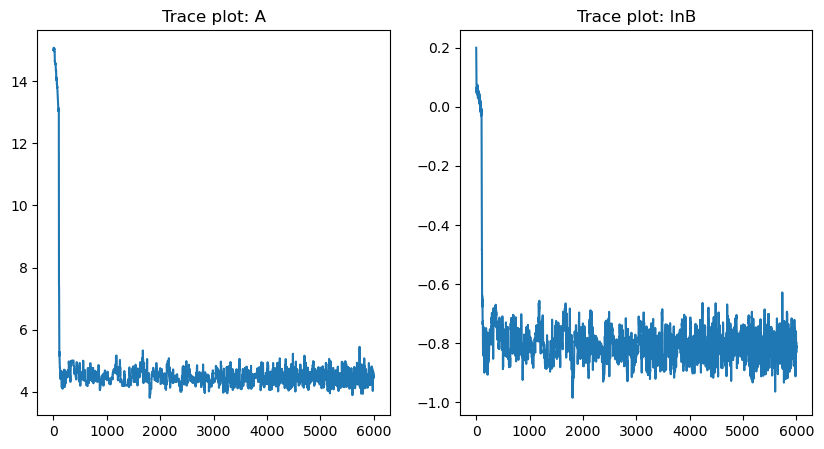

In [249]:
# Load in the chain
chain2 = np.loadtxt('./my_capstone2_ptmcmc_chain/chain_1.txt') # first col 
print(chain2.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(chain2[:,0])
axes[1].plot(chain2[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

(5801, 6)


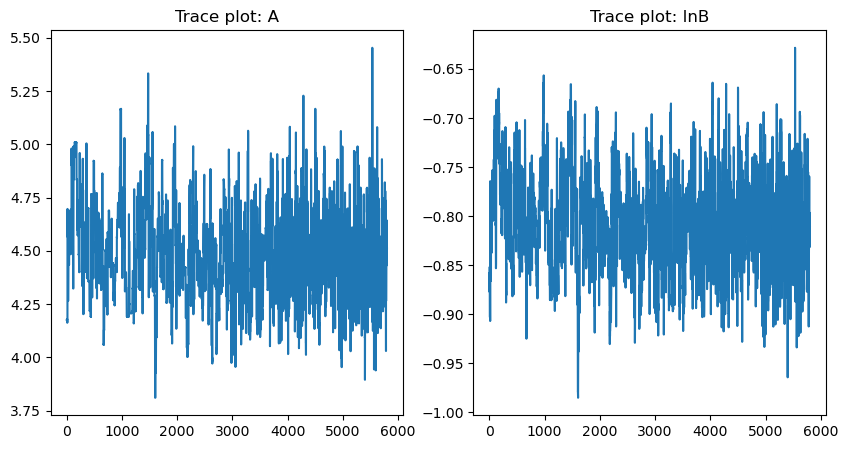

In [250]:
thinchain2 = chain2[200:,:]
print(thinchain2.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(thinchain2[:,0])
axes[1].plot(thinchain2[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

In [252]:
A_acor2 = acor.acor(thinchain2[:,0])[0]
lnB_acor2 = acor.acor(thinchain2[:,1])[0]
print(A_acor2,lnB_acor2)
# the first element of the tuple is the length between independent samples (auto-correlation)
# thin by the nearest integer.

27.731075259382628 23.514582014809584


(208, 6)


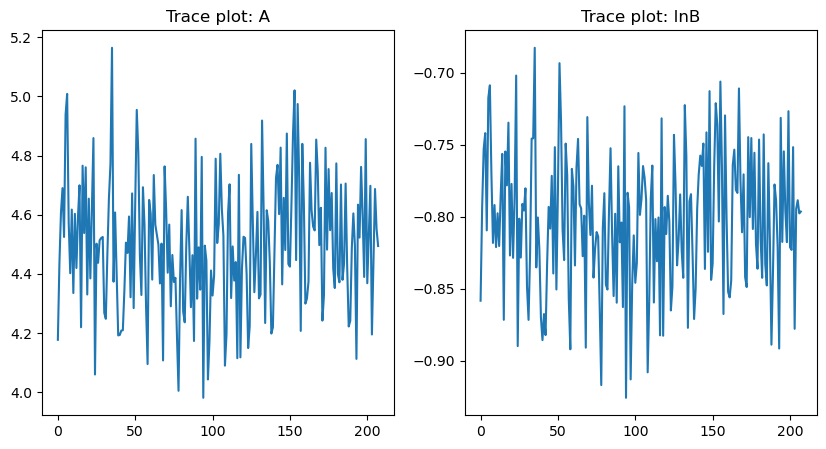

In [253]:
# plot only every 28th point
autochain2 = thinchain2[::28]
print(autochain2.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(autochain2[:,0])
axes[1].plot(autochain2[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

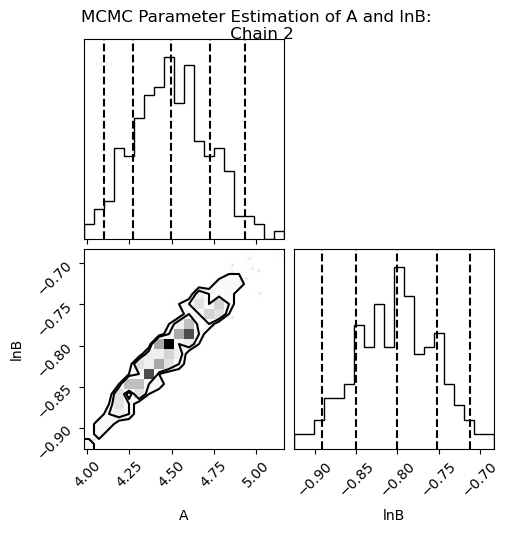

In [660]:
fig = corner.corner(autochain2[:,:2],#take the first two columns
                    labels=['A','lnB'], 
                    quantiles = [0.025,0.16,0.5,0.84,0.975], # for the outside plots
                    levels=[0.68,0.95])
plt.suptitle('MCMC Parameter Estimation of A and lnB: \n Chain 2')
plt.show()

This is better, but running the sampler for hours will allow for the best corner plot results. Try for a third and final time with 3e5 many samples. 

In [450]:
# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler3 = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_capstone3_ptmcmc_chain', resume=False) # dumps into .txt file

# sampler for N steps
N = int(3e5) # should take 7 hours

# array of initial guesses
x0 = np.array([15, 0.2])

# run it! 
sampler3.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50) # using same weights as Lecture 11

Finished 0.33 percent in 81.711749 s Acceptance rate = 0.635

/tmp/ipykernel_738275/2967269309.py:44: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(theta))


Finished 3.33 percent in 746.782563 s Acceptance rate = 0.191767Adding DE jump with weight 50
Finished 100.00 percent in 24551.992070 s Acceptance rate = 0.354607
Run Complete


Finished in 409 minutes = 7 hours. 

In [452]:
# Load in the chain
chain3= np.loadtxt('./my_capstone3_ptmcmc_chain/chain_1.txt') # first col 

(30001, 6)


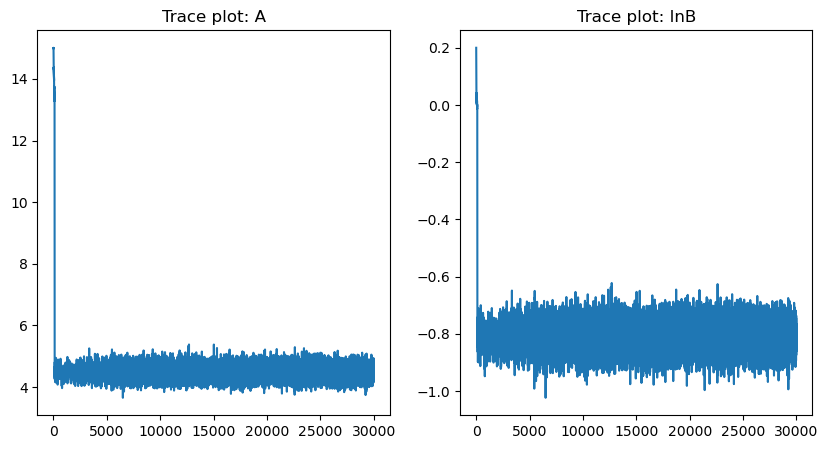

In [457]:
print(chain3.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(chain3[:,0])
axes[1].plot(chain3[:,1])

axes[0].set_title('Initial trace: A')
axes[1].set_title('Initial trace: lnB')
plt.show()

(29801, 6)


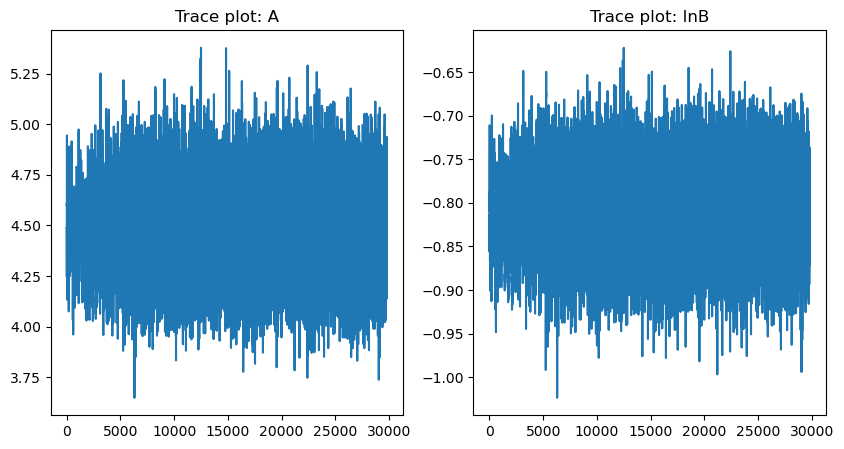

In [464]:
thinchain3 = chain3[200:,:]
print(thinchain3.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(thinchain3[:,0])
axes[1].plot(thinchain3[:,1])

axes[0].set_title('Trace plot: A')
axes[1].set_title('Trace plot: lnB')
plt.show()

In [465]:
A_acor3 = acor.acor(thinchain3[:,0])[0]
lnB_acor3 = acor.acor(thinchain3[:,1])[0]
print(A_acor3,lnB_acor3)
# the first element of the tuple is the length between independent samples (auto-correlation)
# thin by the nearest integer.

6.075432575242088 6.143798870695218


(4967, 6)


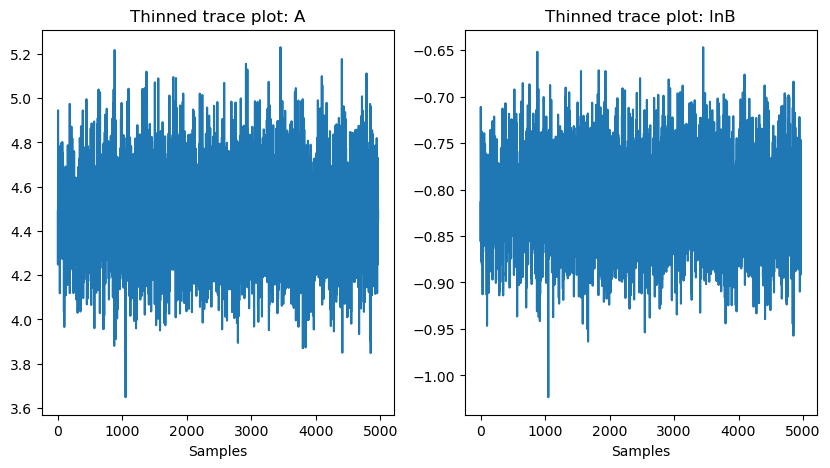

In [495]:
# plot only every 6th point
autochain3 = thinchain3[::6]
print(autochain3.shape)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(autochain3[:,0])
axes[1].plot(autochain3[:,1])

axes[0].set_title('Thinned trace plot: A')
axes[0].set_xlabel('Samples')
axes[1].set_title('Thinned trace plot: lnB')
axes[1].set_xlabel('Samples')

plt.show()

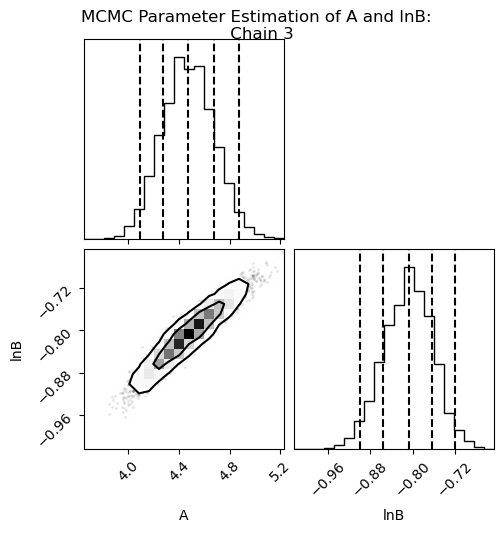

In [659]:
fig = corner.corner(autochain3[:,:2],#take the first two columns
                    labels=['A','lnB'], 
                    quantiles = [0.025,0.16,0.5,0.84,0.975], # for the outside plots
                    levels=[0.68,0.95])
plt.suptitle('MCMC Parameter Estimation of A and lnB: \n Chain 3')
plt.show()

This third result is by far the best.

Concatenate the three burned and thinned chains (no need to burn and thin again) and find the final corner plot.

In [497]:
print(autochain.shape)
print(autochain2.shape)
print(autochain3.shape)

(148, 6)
(208, 6)
(4967, 6)


In [498]:
finalchain = np.concatenate([autochain,autochain2,autochain3])
print(finalchain.shape)

(5323, 6)


Quantiles:
[(0.025, 4.089553590947725), (0.16, 4.270928648227085), (0.5, 4.472536427137403), (0.84, 4.678172124055003), (0.975, 4.875719391088382)]
Quantiles:
[(0.025, -0.899714230928346), (0.16, -0.8548773804310267), (0.5, -0.8067148943239276), (0.84, -0.7632996484060445), (0.975, -0.7205747321650008)]


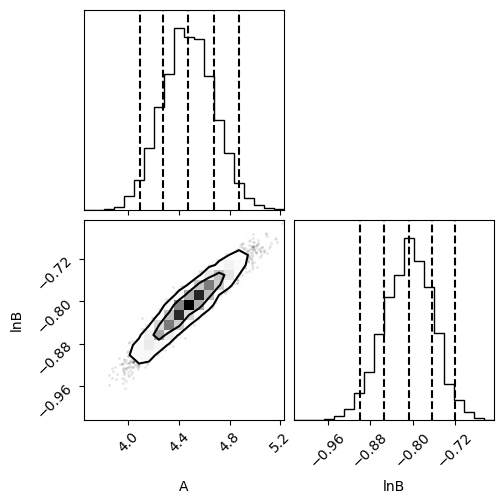

In [526]:
fig = corner.corner(finalchain[:,:2],#take the first two columns
                    labels=['A','lnB'], 
                    quantiles = [0.025,0.16,0.5,0.84,0.975], # for the outside plots
                    levels=[0.68,0.95],
                    verbose=True)
#plt.suptitle('MCMC Parameter Estimation of A and lnB \n')
plt.show()

In [613]:
bestTheta = [4.472536427137403,-0.8067148943239276]

Create the summary plot of the burning and thinning process.

(3, 2)


Text(0.5, 1.0, 'Final thinned trace: lnB')

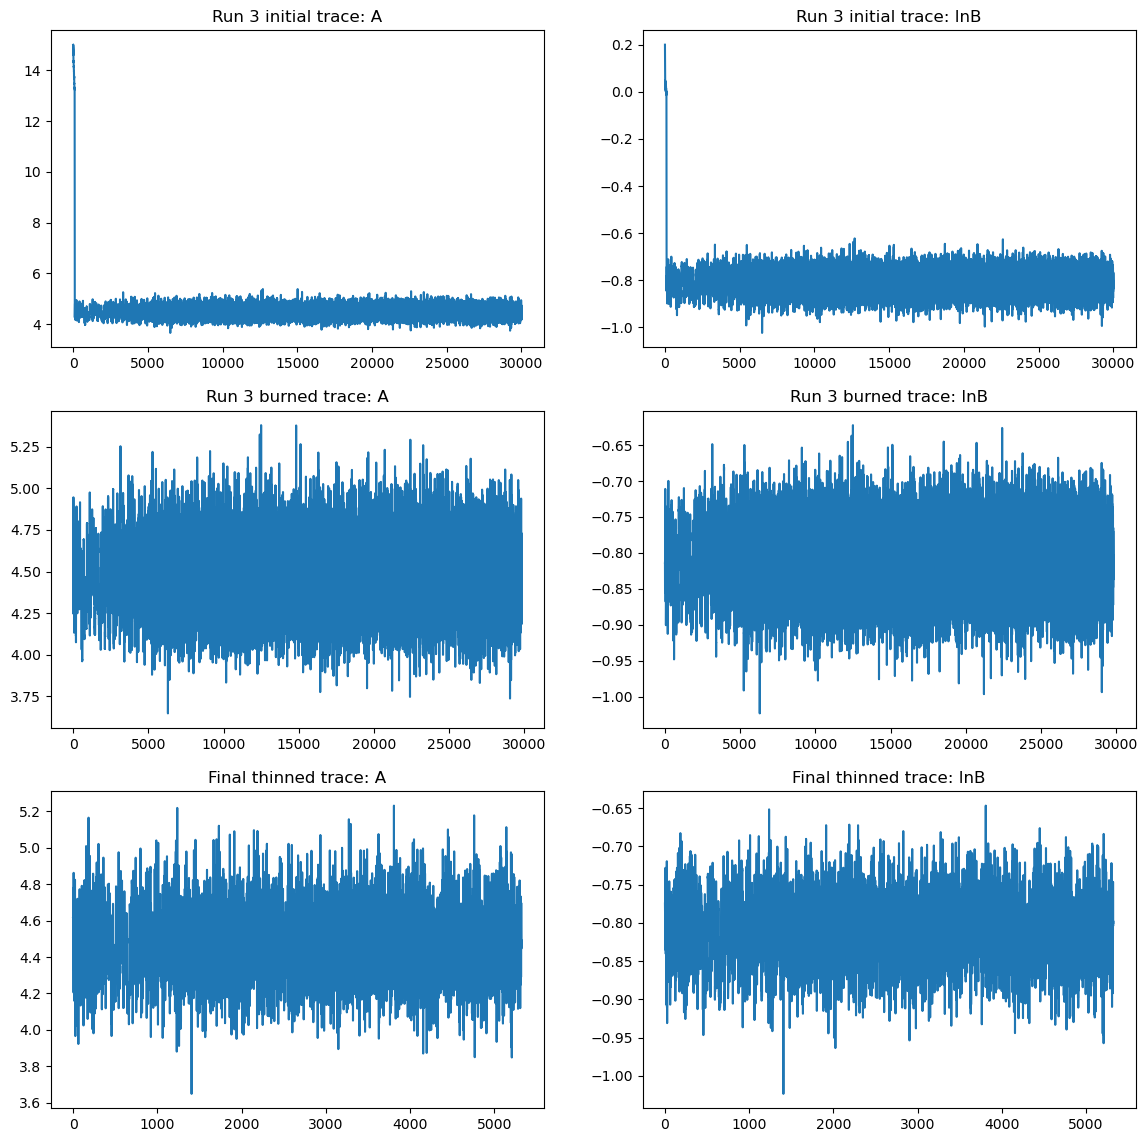

In [522]:
fig, axes = plt.subplots(3,2,figsize=(14,14))
print(axes.shape)

axes[0][0].plot(chain3[:,0])
axes[0][1].plot(chain3[:,1])
axes[0][0].set_title('Run 3 initial trace: A')
axes[0][1].set_title('Run 3 initial trace: lnB')

axes[1][0].plot(thinchain3[:,0])
axes[1][1].plot(thinchain3[:,1])
axes[1][0].set_title('Run 3 burned trace: A')
axes[1][1].set_title('Run 3 burned trace: lnB')

axes[2][0].plot(finalchain[:,0])
axes[2][1].plot(finalchain[:,1])
axes[2][0].set_title('Final thinned trace: A')
axes[2][1].set_title('Final thinned trace: lnB')

## Model comparison

Plot the models against the data for visual comparison. 

In [648]:
minz_reduced = min(reds)
maxz_reduced = max(reds)
minSep_reduced = min(seps)
maxSep_reduced = max(seps)

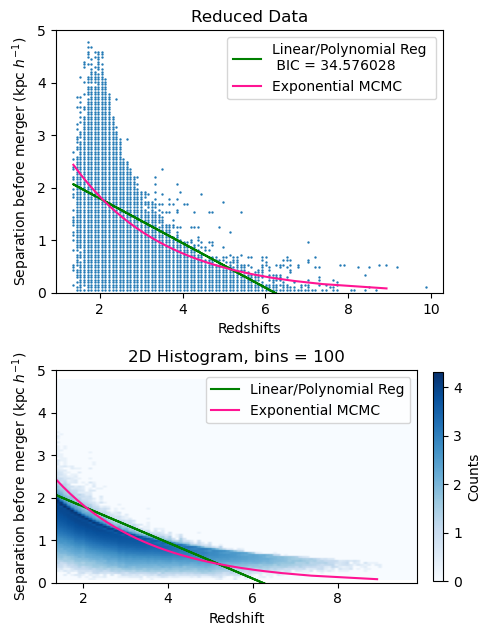

In [656]:
fig, axes = plt.subplots(2,1,figsize=(5,7.5))

# plot scatter with linear and exponential fits
sortedxtest = np.sort(xtest)
expFit = expModel(theta=bestTheta,data=[sortedxtest,ytest])

axes[0].scatter(reds,seps,s=0.5)
#axes[0].plot(xtest,linFit,color='red',linewidth=3,label='Linear Reg')
axes[0].plot(xtest,polyfit,color='green',label='Linear/Polynomial Reg \n BIC = %f'%linBIC)
axes[0].plot(sortedxtest,expFit,color='deeppink',label='Exponential MCMC')
axes[0].set_title('Reduced Data')
axes[0].set_xlabel('Redshifts')
axes[0].set_ylabel('Separation before merger (kpc $h^{-1}$)')
axes[0].set_ylim(0,5)
axes[0].legend()

# plot histogram with linear and exponential fits
im = axes[1].imshow(logHist.T,origin='lower',extent=[minz_reduced,maxz_reduced,minSep_reduced,maxSep_reduced],cmap='Blues')
axes[1].plot(xtest,linFit,color='green',label='Linear/Polynomial Reg')
axes[1].plot(sortedxtest,expModel(theta=bestTheta,data=[sortedxtest,ytest]),color='deeppink',label='Exponential MCMC')
axes[1].set_title('2D Histogram, bins = 100')
axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('Separation before merger (kpc $h^{-1}$)')
cbar = plt.colorbar(im, fraction=0.027, pad=0.04)
cbar.set_label('Counts')
axes[1].set_ylim(0,5)
axes[1].legend()

plt.show()

Compare the models numerically with BIC scores and RMS errors

In [617]:
linErr = errs[0]
linBIC = bics[0] # degree = 1 was the first iteration appended to errs and bics lists

k_BIC = 2 # number of parameters
N = len(ytest)
expErr = np.sqrt(np.sum((expFit - ytest) ** 2)/ len(ytest))
expBIC = np.sqrt(len(ytest)) * (expErr/dy) + k_BIC * np.log(N)

print('Linear/Poly RMS:',linErr)
print('Exponential RMS:',expErr)
print('Linear/Poly BIC:',linBIC)
print('Exponential BIC:',expBIC)

Linear/Poly RMS: 1.3260788671444772
Exponential RMS: 1.3408602474755154
Linear/Poly BIC: 34.57602836984629
Exponential BIC: 30.180836405408975


Exponential wins!